# <span style="background: linear-gradient(135deg,#fce38a,#f38181); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 32pt;">Numerical Solver</span>

## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">FDM</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class FDMSolver:
    def __init__(self, n_points=101, mu=1.0):
        self.n_points = n_points
        self.mu = mu
        self.x = np.linspace(0, 1, n_points)
        self.dx = 1.0 / (n_points - 1)
        self.u = np.linspace(0, 1, n_points) 
    def compute_residual(self, u):
        d2u_dx2 = np.zeros_like(u)
        du_dx = np.zeros_like(u)
        d2u_dx2[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / (self.dx**2)
        du_dx[1:-1] = (u[2:] - u[:-2]) / (2*self.dx)
        residual = d2u_dx2 - self.mu * (1 - u**2) * du_dx + u
        residual[0] = u[0] - 0  
        residual[-1] = u[-1] - 1  
        return residual
    
    def compute_jacobian(self, u):
        n = len(u)
        J = np.zeros((n, n))
        for i in range(1, n-1):
            J[i, i-1] = 1.0 / (self.dx**2)
            J[i, i] = -2.0 / (self.dx**2)
            J[i, i+1] = 1.0 / (self.dx**2)
            J[i, i] += 1.0  
            J[i, i] += self.mu * 2 * u[i] * (u[i+1] - u[i-1]) / (2*self.dx)
            J[i, i-1] += -self.mu * (1 - u[i]**2) / (2*self.dx)
            J[i, i+1] += self.mu * (1 - u[i]**2) / (2*self.dx)
        J[0, 0] = 1.0
        J[-1, -1] = 1.0
        
        return J
    
    def solve(self, max_iter=50, tol=1e-6):
        u = self.u.copy()
        
        for iter in tqdm(range(max_iter), desc="Newton iterations"):
            r = self.compute_residual(u)
            if np.max(np.abs(r)) < tol:
                print(f"Converged after {iter+1} iterations")
                break
            J = self.compute_jacobian(u)
            du = np.linalg.solve(J, -r)
            u += du
            
        self.u = u
        return u, np.mean(r**2)
    
    def plot_solution(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.x, self.u, 'r-', linewidth=2, label='Numerical solution')
        plt.plot(self.x, np.sin(self.x)/np.sin(1), 'r-', linewidth=2, label='Exact solution', alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title(f'FDM solution with μ={self.mu}')
        plt.grid(True)
        plt.legend()
        plt.savefig('fdm_solution.png', dpi=300, bbox_inches='tight')
        plt.close()
        
if __name__ == "__main__":
    solver = FDMSolver(n_points=1001, mu=1)
    u_fdm, r = solver.solve(max_iter=1000)
    print(f"MSE: {r}")
    # save the solution
    np.savetxt('../../../data/fdm_vanderpol_sol.csv', np.vstack((solver.x, u_fdm)).T,delimiter=",", comments="", fmt="%.6f")

Newton iterations:   1%|          | 11/1000 [00:02<03:53,  4.23it/s]

Converged after 12 iterations
MSE: 2.2332931330941473e-13


## <span style="background: linear-gradient(135deg,#f54ea2,#ff7676); -webkit-background-clip: text; color: transparent;font-weight: bold; font-style: italic; font-size: 24pt;">PINN</span>

### Train step 

In [2]:
import torch
import torch.nn as nn
from ssde.pde import function_map
import matplotlib.pyplot as plt
import numpy as np

mu_value = 1
np.random.seed(0)
torch.manual_seed(0)
class vanderpol(nn.Module):
    def __init__(self):
        super(vanderpol, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        t = torch.tanh(self.fc1(x))
        t = torch.tanh(self.fc2(t))
        t = self.fc3(t)
        return t * (1 - x) * x + x
    
# define the loss function
def loss_fn(y_pred, x):
    # embedding the boundary conditions
    y_pred = function_map["van_der_pol"](y_pred, x, mu=mu_value)
    return torch.mean(y_pred**2)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = vanderpol().to(device)

/home/weishu/.conda/envs/SymPDE/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1000, loss = 4.1866141486934794e-07
Epoch 2000, loss = 4.810641662800208e-09


In [ ]:
# define the training function
def train(model, x, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, x)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f"Epoch {epoch+1}, loss = {loss.item()}")

# train the model
x = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1).to(device)
x.requires_grad = True
train(model, x, epochs=2000, lr=0.01)
# save the model
torch.save(model.state_dict(), "vanderpol.pth")

### Evaluation

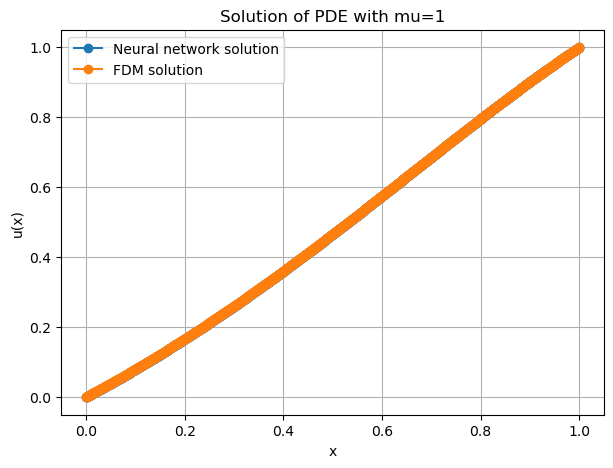

In [6]:
# plot the solution
# test
import torch
mu_value = 1
sample_number = 1000
test_x = np.linspace(0, 1, sample_number).reshape(-1, 1)
test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(test_x)
    plt.figure(figsize=(7,5))
    plt.plot(test_x.cpu().numpy(), y_pred.cpu().numpy(), "o-", label="Neural network solution")
    if mu_value == 0:
        plt.plot(test_x.cpu().numpy(), np.sin(test_x.cpu().numpy())/np.sin(1), "o-", label="Exact solution")
    plt.plot(test_x.cpu().numpy(), u_fdm[1:], "o-", label="FDM solution")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title(f"Solution of PDE with mu={mu_value}")
    plt.legend()
    plt.grid(True)
    plt.show()